# MC886 - Aprendizado de Máquina
# Trabalho 3
- Guilherme Ramirez - RA217295
- Frederico Rappa - RA216047

-----------------------------------------------
# Bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_style("whitegrid")
FONTSIZE = 20
TICKFONTSIZE = 15

-----------------------------------------------------------------------------------------------------------------
# Funções auxiliares

In [4]:
from util import *
import traceback
import sys, types, time, random, os
from game import Agent, Directions, AgentState, Grid, Actions, GameStateData

In [5]:
from util import nearestPoint
from util import manhattanDistance
from pacman import GameState, loadAgent, parseAgentArgs, ClassicGameRules
import util
import layout as lo

def setConfig(pacman, numGames=1, numTraining=0, layout='mediumClassic', quietGraphics=True, fixRandomSeed=False, agentArgs=None, timeout=30):
    args = dict()
    noKeyboard = True
    if fixRandomSeed:
        random.seed('cs188')

    args['layout'] = lo.getLayout( layout )
    pacmanType = loadAgent(pacman, noKeyboard)
    agentOpts = parseAgentArgs(agentArgs)
    pacman = pacmanType(**agentOpts) 
    args['pacman'] = pacman

    if numTraining > 0:
        args['numTraining'] = numTraining
        if 'numTraining' not in agentOpts: 
            agentOpts['numTraining'] = numTraining

    if 'numTraining' in agentOpts:
        numQuiet = int(agentOpts['numTraining'])
        numIgnore = int(agentOpts['numTraining'])

    ghostType = loadAgent('RandomGhost', noKeyboard)
    args['ghosts'] = [ghostType( i+1 ) for i in range( 4 )]

    # Choose a display format
    if quietGraphics:
        import textDisplay
        args['display'] = textDisplay.NullGraphics()
    else:
        import graphicsDisplay
        args['display'] = graphicsDisplay.PacmanGraphics(options.zoom, frameTime = options.frameTime)
    args['numGames'] = numGames
    args['timeout'] = timeout

    return args


def runGames( layout, pacman, ghosts, display, numGames, numTraining = 0, catchExceptions=False, timeout=30 ):
    print('=====================================================')
    import __main__
    __main__.__dict__['_display'] = display

    rules = ClassicGameRules(timeout)
    games = []

    for i in range( numGames ):
        beQuiet = i < numTraining
        if beQuiet:
                # Suppress output and graphics
            import textDisplay
            gameDisplay = textDisplay.NullGraphics()
            rules.quiet = True
        else:
            gameDisplay = display
            rules.quiet = False
        game = rules.newGame( layout, pacman, ghosts, gameDisplay, beQuiet, catchExceptions)
        totalFood = game.state.getNumFood()
        if numTraining > 0:
            game.run(epsilon = (numTraining - i)/numTraining)
        else:
            game.run()
        games.append(game)
        if (i + 1) % 100 == 0 and i + 1 <= numTraining or i + 1 == numTraining:
            print('Trained episode {}'.format(i+1))
            


    print('=====================================================')
    data={}
    data['numTraining'] = numTraining
    data['numGames'] = numGames
    data['scores'] = np.array([game.state.getScore() for game in games])
    data['wins'] = [game.state.isWin() for game in games]
    data['winRate'] = data['wins'].count(True)/ float(len(data['wins']))
    data['averageScore'] = np.mean(data['scores'])
    data['numFood'] = np.array([game.state.getNumFood() for game in games])
    data['foodEaten'] = np.array([(totalFood - game.state.getNumFood())/totalFood for game in games])
    data['numMoves'] = np.array([game.numMoves for game in games])
    

    return games, data

In [6]:
def getWins(data):
    s = 0
    numWins = np.zeros(data['numGames'])
    for i in range(data['numGames']):
        if data['wins'][i]:
            s += 1
        numWins[i] = s
    return numWins

In [7]:
def mediaMovel(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

-----------------------------------------------------------------------------------------------------------------
# PART I - Evolutionary Model

## Definição do Modelo

# PART II - Reinforcement Learning

## Definição do Modelo

Para a seção de aprendizado por reforço, foi desenvolvido o agente `QLearningAgent`, que utiliza o método Q-Learning.

|  Método         | Explicação |
|:---------:|:---------------:|
| `hasThreateningGhosts` |      Verifica se existem fantasmas ameaçadores na posição     |   
| `getNeighbours` |      Retorna lista de vizinhos acessíveis      |   
| `getValidNeighbours` |      Retorna lista de vizinhos acessíveis e sem fantasmas      |   
| `getClosestFoodDistance` |      Devolve a distância da comida mais próxima, sua posição e a direção que deve ser tomada para que o pacman chegue a ela      |   
| `getClosestGhostDistance` |     Devolve o fantasma não amedrontado mais próximo e sua posição      |   
| `hasThreateningGhostInDirection` |     Verifica se há um fantasma ameaçador em um número máximo de casas a partir do pacman      |   
| `fruitInRadius` |     Devolve o número de fruntas em um raio      |   
| `ghostsInRadius` |      Devolve o número de fantasmas amedrontados e ameaçadores em um raio      |   
| `getTileType` |      Devolve qual dos 16 tipos de 'casa' corresponde uma coordenada      |   
| `isTrapped` |      Verifica se o pacman estáa preso: se há fantasmas bloqueando suas saídas      |   
| `getRelativeQuadrant` |      Devolve o quadrante de uma coordenada relativo ao pacman      |   
| `getQState` |     Mapeia o estado do pacman      |   
| `getRewardFromState` |     Devolve uma recompensa a partir de um estado     |   
| `getAction` |     Devolve a melhor ação do pacman      |  


A cada instante, o pacman está em um de 2048 estados possíveis, definidos pelas seguintes features:
- direção do menor caminho não bloqueado por fantasmas ameaçadores para a comida mais próxima – 4 valores; **(I)** 
- "tipo" da posição em que se encontra o Pacman / configuração dos muros a seu redor – 16 valores; **(II)** 
- variável booleana que indica que pacman está "preso" – 2 valores; **(III)** 
- fantasma ameaçador a 8 blocos de distância em um caminho iniciado nas posições adjacentes ao Pacman – 16 valores; **(IV)** 

A cada momento, o pacman verifica quais ações são legais e executa uma entre as 4 possíveis, se locomovendo para Norte, Sul, Leste e Oeste. A cada ação, o pacman recebe uma recompensa, que é dada da seguinte maneira: se o agente ganha o jogo ou come uma fruta, é recompensado positivamente; se perde o jogo ou não come há mais de 10 turnos, é recompensado negativamente. A implementação exata com os valores das recompensas pode ser vista no método `getRewardFromState`. 

Apesar do número de estados ser pequeno, foi possível ver que generalizam bem o tabuleiro do pacman, uma vez que independem de valores como distância, número total de fantasmas ou configuração do *grid*, de modo que, em teoria, um pacman treinado exaustivamente em uma configuração teria o mesmo comportamento em configurações diferentes. Além disso, notou-se que, em alguns testes, o pacman já vencia jogos com cerca de 100 episódios de treinamento, valor muito inferior ao de outras abordagens testadas pela dupla. Enquanto a *feature* **I** objetiva a inferência do melhor caminho para uma recompensa, a **IV** evita que o pacman vá para locais ameaçadores, mesmo que potencialmente tenham esta recompensa. As demais *features* são úteis para que o pacman fuja de fantasmas. 

Para o treinamento, foi utilizada a política epsilon-greedy: o valor de epsilon começou em 1 e decaiu a 0 até o final do treinamento. Antes da adoção desta política, era utilziado epsilon *constante*, de valor 0.3, mas esta abordagem foi descartada em razão do melhor resultado do epsilon-greedy com o número reduzido de estados. Por outro lado, *gamma* e *alpha* foram mantidos constantes, de valores 0.7 e 0.9, respectivamente, pois notou-se que esta formulação produzia melhores resultados mais rapidamente.  

Em todos os episódios, o critério de parada foi o momento em que o pacman vencia ou perdia o jogo.

A implementação do agente é mostrada abaixo:

In [8]:
from QLearningAgents import QLearningAgent 

## Treinamento 

### mediumClassic
Para esta configuração, são feitos 5000 episódios de treinamento e 1000 de teste

In [30]:
QLearningAgent.resetState()
args = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000 )
games, data = runGames( **args )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

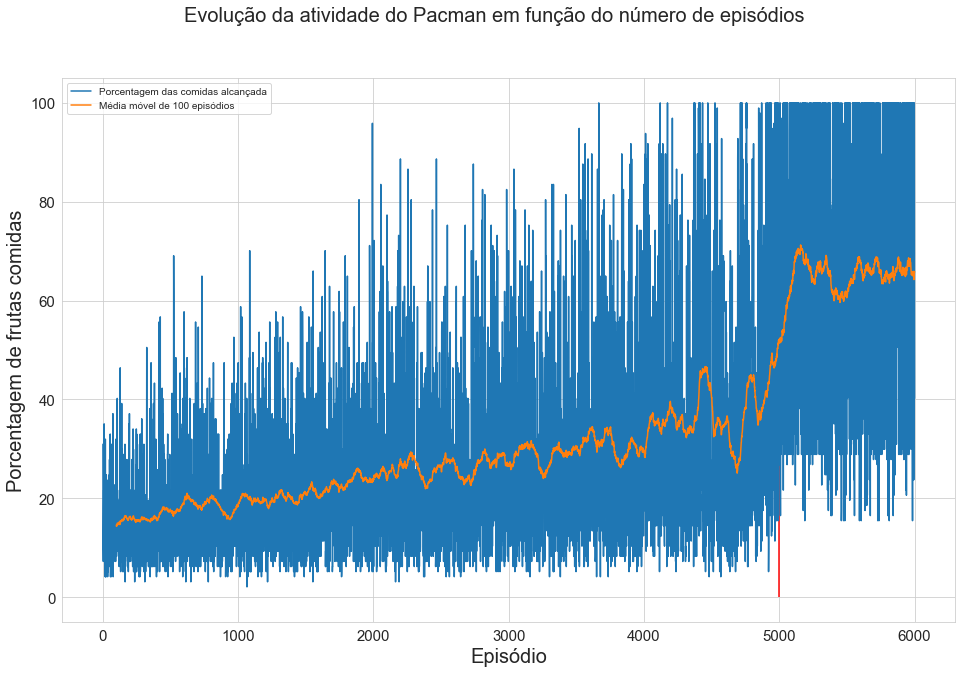

In [152]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, data['numGames'] + 1), data['foodEaten']*100)
mm, = ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

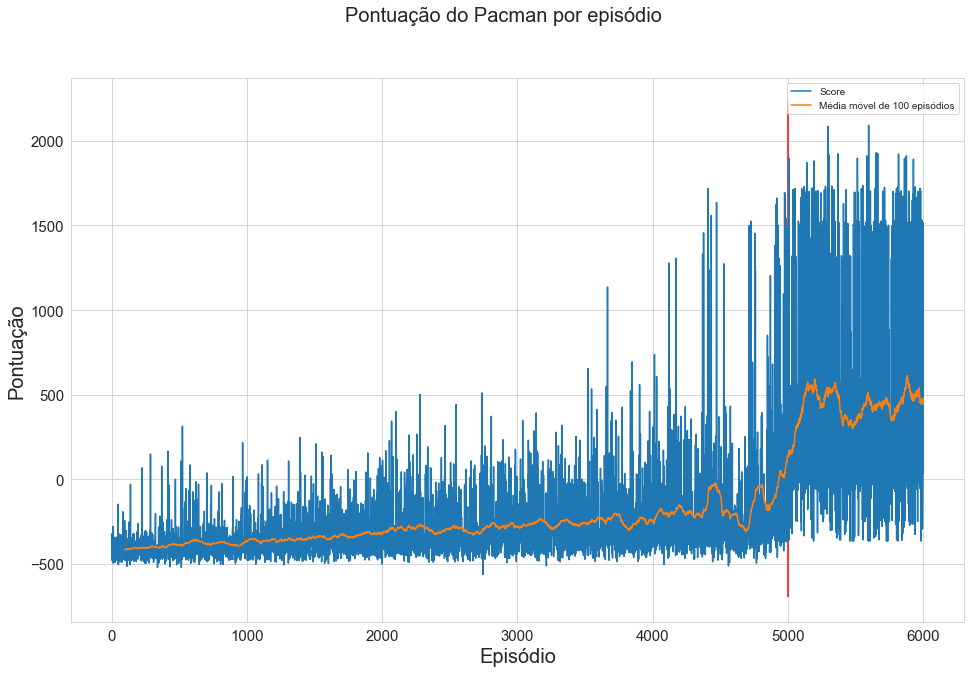

In [150]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), data['scores'])
ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

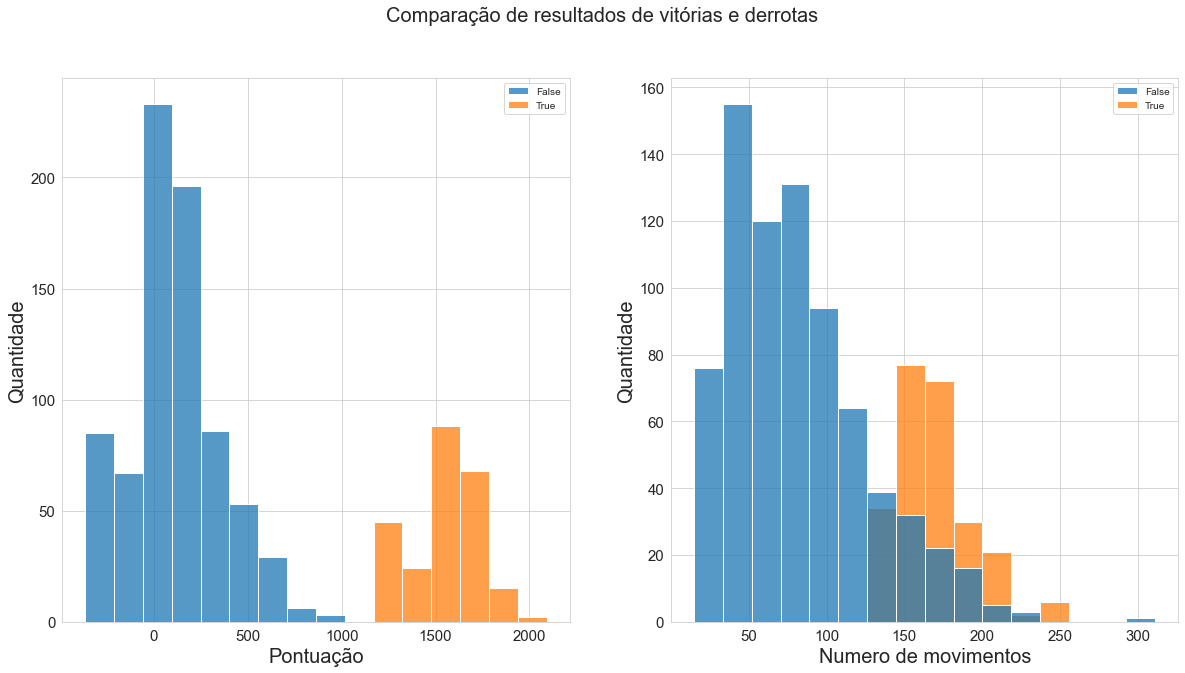

In [238]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=data['scores'][5000:], hue=data['wins'][5000:], ax=axs[0])
sns.histplot(x=data['numMoves'][5000:], hue=data['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

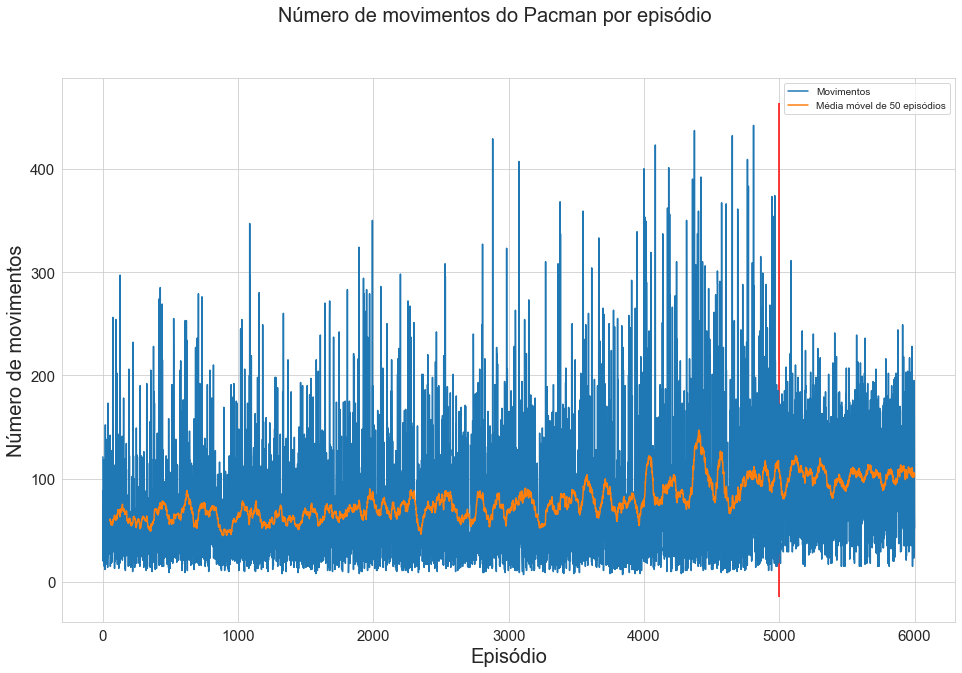

In [163]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), data['numMoves'])
ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

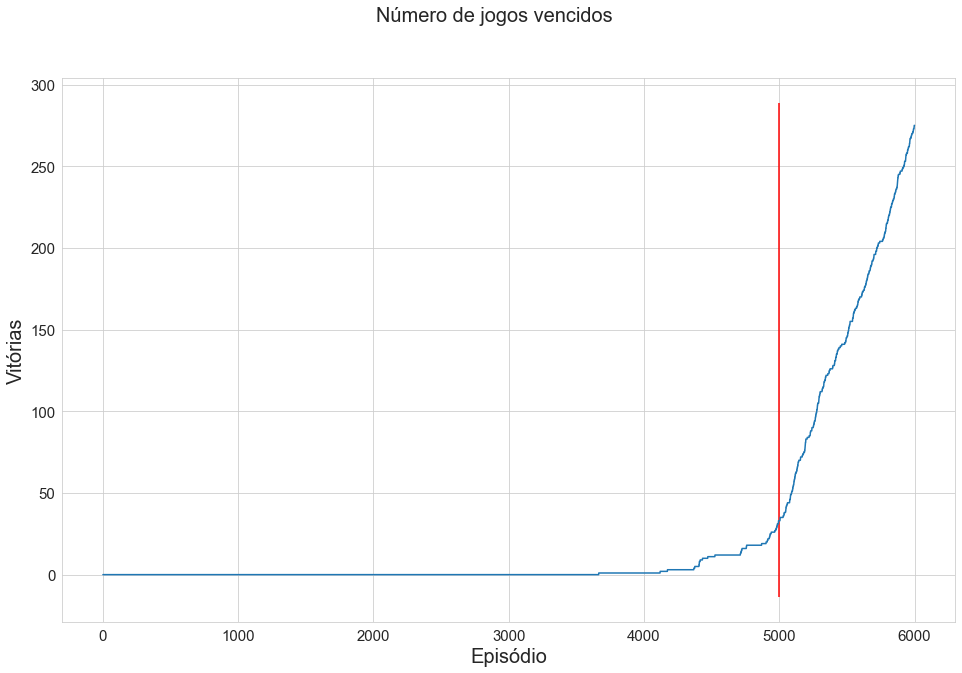

In [209]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), getWins(data))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

In [61]:
data['winRate']
data['wins'][data['numTraining']:].count(True)/ float(data['numGames'] - data['numTraining'])

0.242

Excluindo as vitórias no período de treinamento, o modelo obteve 24,2% de vitórias.

In [77]:
pd.DataFrame(np.array(data['wins']))[0].value_counts()

False    5725
True      275
Name: 0, dtype: int64

### smallClassic

In [16]:
QLearningAgent.resetState()
smallClassicArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000, layout='smallClassic' )
smallClassicGames, smallClassicData = runGames( **smallClassicArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

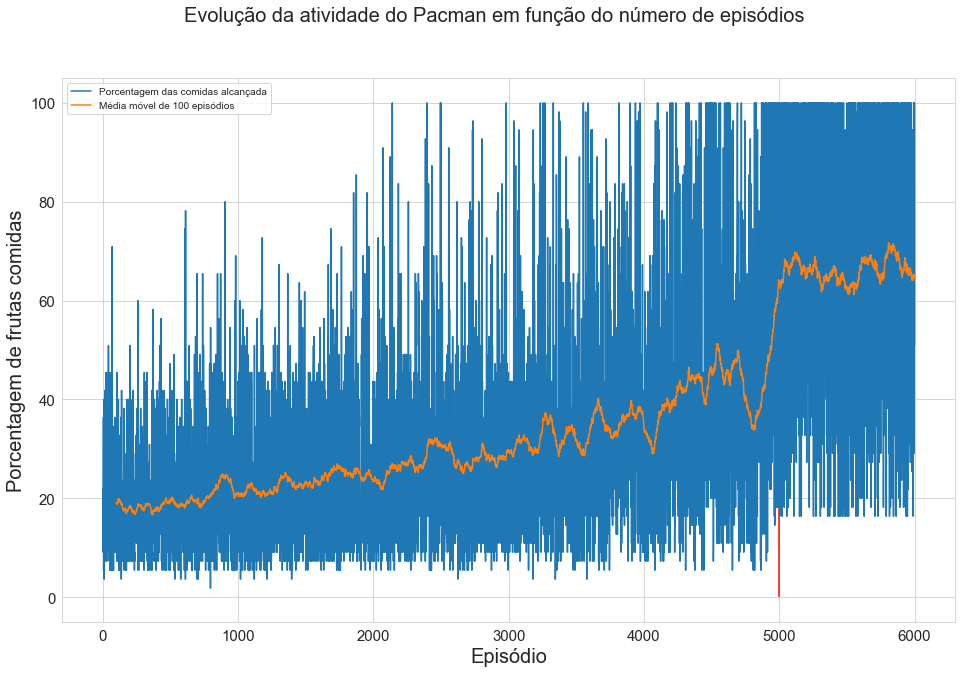

In [17]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['foodEaten']*100)
mm, = ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

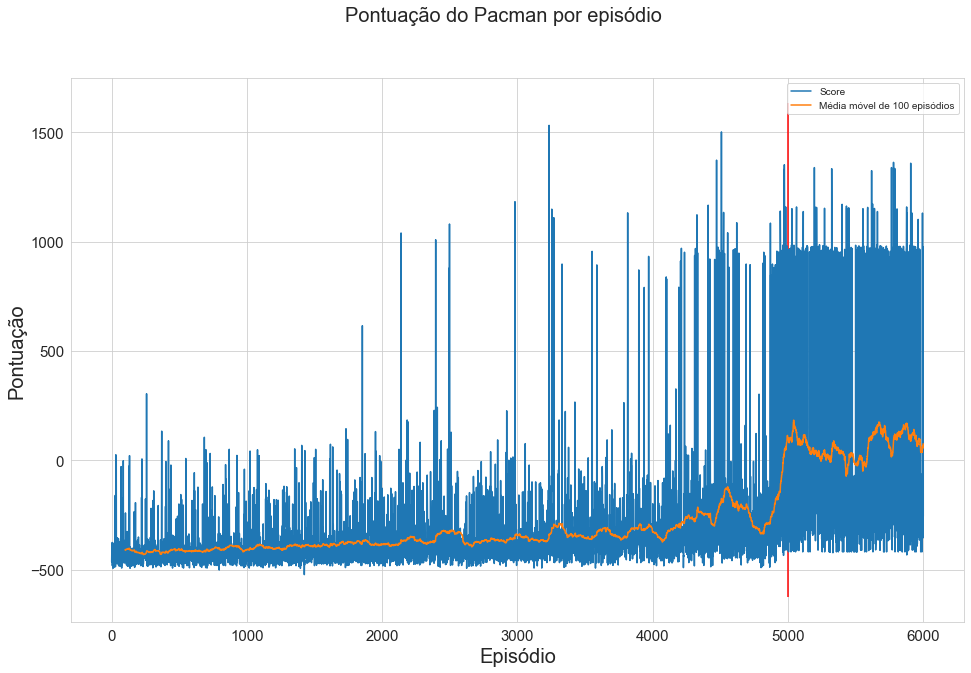

In [22]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['scores'])
ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

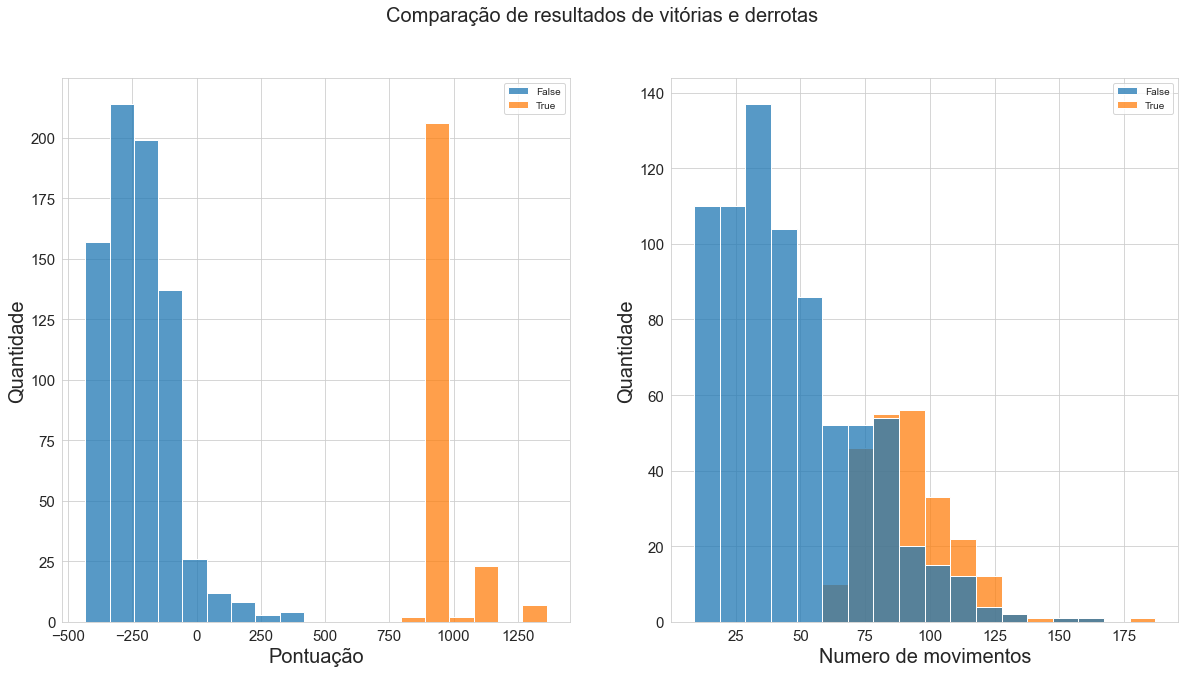

In [23]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=smallClassicData['scores'][5000:], hue=smallClassicData['wins'][5000:], ax=axs[0])
sns.histplot(x=smallClassicData['numMoves'][5000:], hue=smallClassicData['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

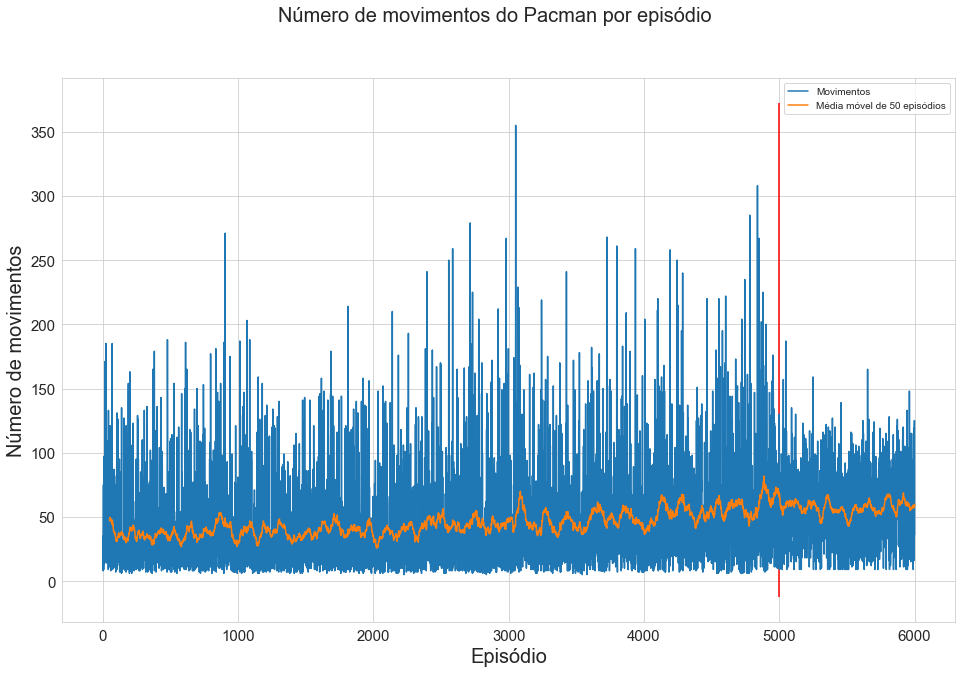

In [24]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['numMoves'])
ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

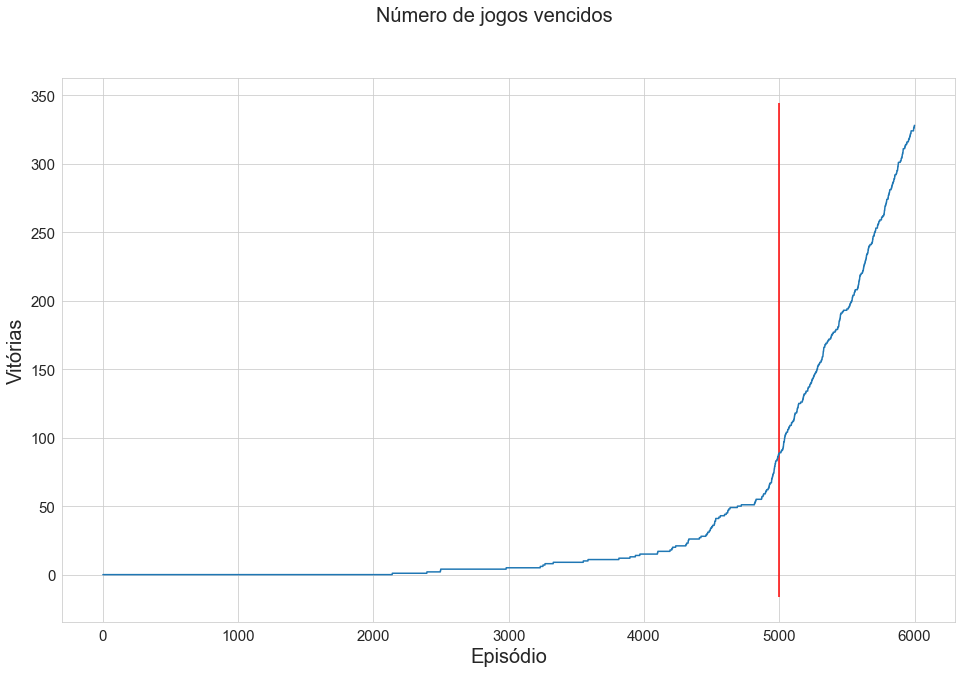

In [25]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), getWins(smallClassicData))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

In [26]:
smallClassicData['wins'][smallClassicData['numTraining']:].count(True)/ float(smallClassicData['numGames'] - smallClassicData['numTraining']) 

0.24

4,6% de vitórias

### originalClassic

In [10]:
QLearningAgent.resetState()
originalClassicArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000, layout='originalClassic' )
originalClassicGames, originalClassicData = runGames( **originalClassicArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

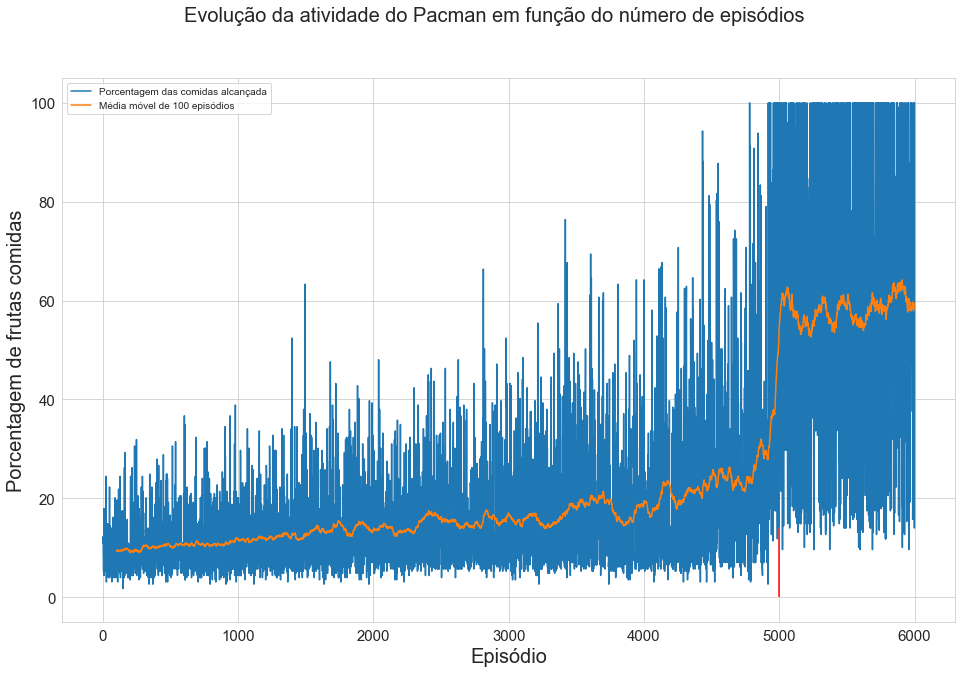

In [11]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['foodEaten']*100)
mm, = ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

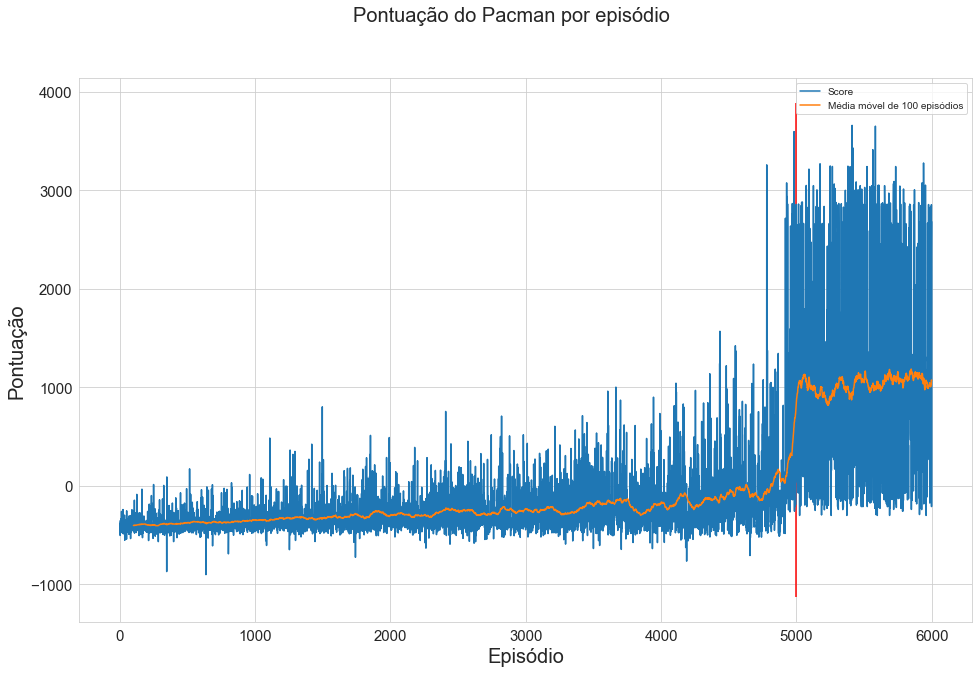

In [12]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['scores'])
ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

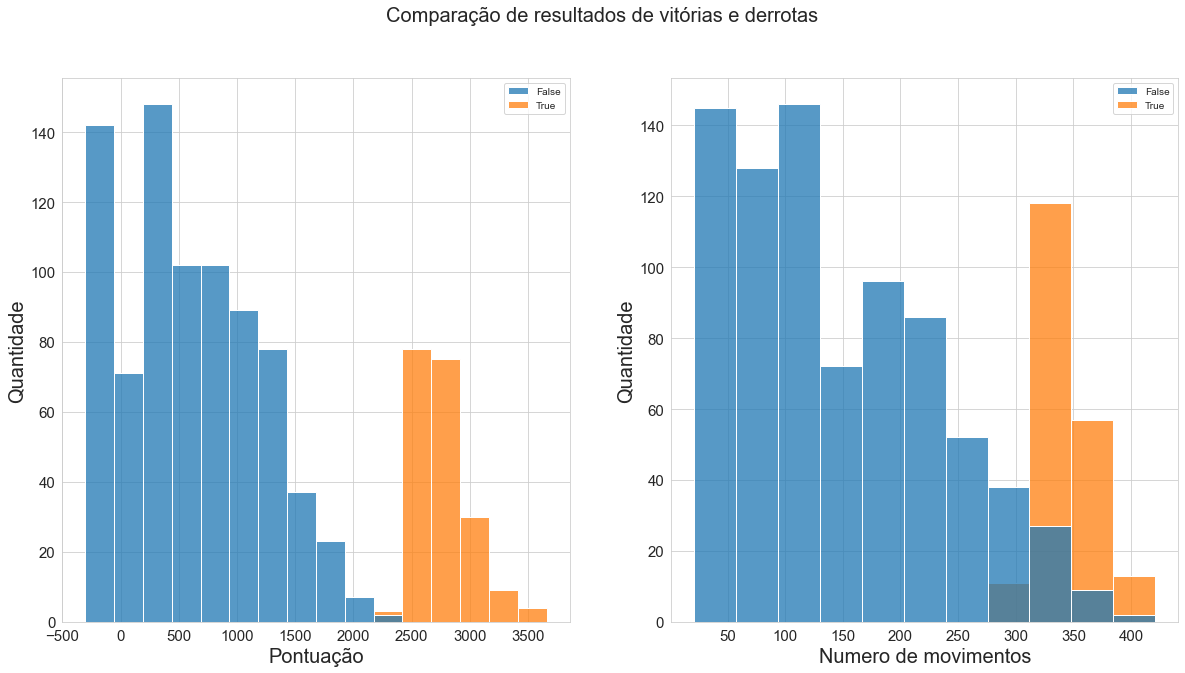

In [13]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=originalClassicData['scores'][5000:], hue=originalClassicData['wins'][5000:], ax=axs[0])
sns.histplot(x=originalClassicData['numMoves'][5000:], hue=originalClassicData['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

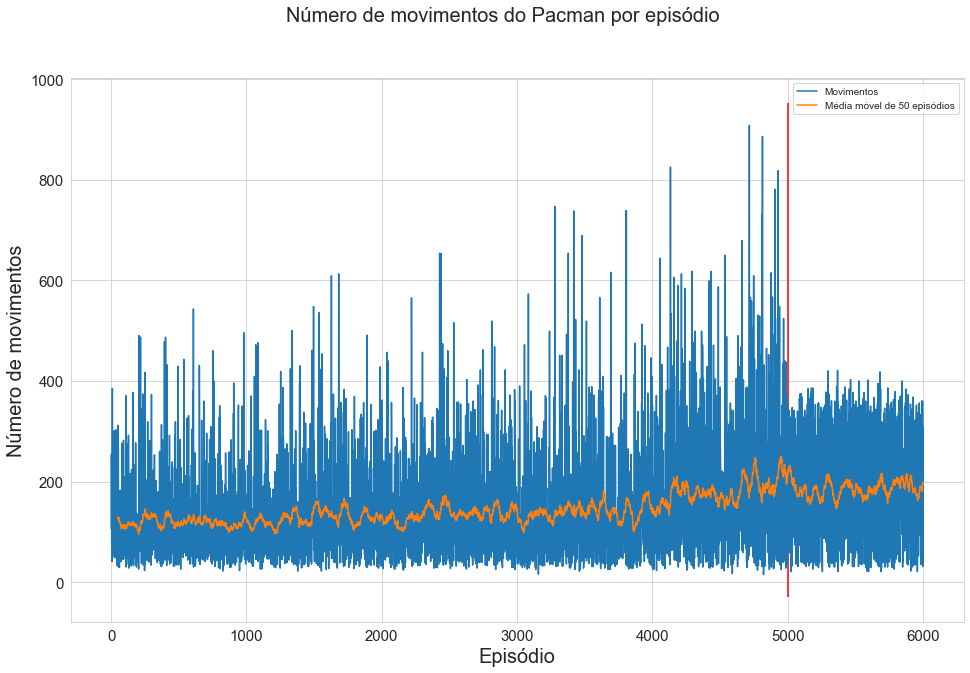

In [14]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['numMoves'])
ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

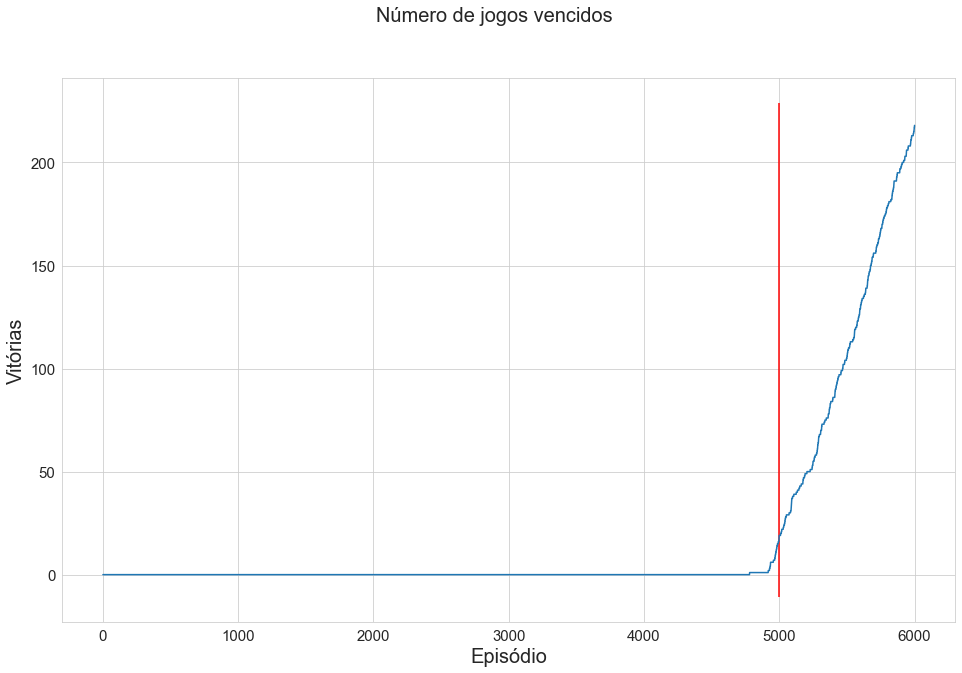

In [15]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), getWins(originalClassicData))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

In [17]:
originalClassicData['wins'][originalClassicData['numTraining']:].count(True)/ float(originalClassicData['numGames'] - originalClassicData['numTraining']) 

0.199

19,9% vencidos

In [23]:
originalClassicData['foodEaten']

array([0.10917031, 0.10917031, 0.12227074, ..., 1.        , 0.13973799,
       1.        ])

## Testes a partir do treinamento em mediumClassic
Como exposto, em teoria, os estados do agente criado devem ser robustos o suficiente para permitir que o pacman vença em outros layouts. Esta hipótese será avaliada a seguir,a partir do uso do agente treinado nos 5000 episódios em mediumClassic nos dois outros layouts.

### smallClassic
O modelo treinado anteriormente foi aplicado abaixo.

In [83]:
smallArgs = {'layout': lo.getLayout('smallClassic'), 'pacman': args['pacman'], 'ghosts': args['ghosts'], 'display': args['display'], 'numGames': 1000, 'numTraining' : 0}
smallGames, smallData = runGames( **smallArgs )

Dos 1000 episódios avaliados, o pacman venceu 12,9%.

In [217]:
smallData['winRate']

0.129

### originalClassic

In [210]:
largeArgs = {'layout': lo.getLayout('originalClassic'), 'pacman': args['pacman'], 'ghosts': args['ghosts'], 'display': args['display'], 'numGames': 1000, 'numTraining' : 0}
largeGames, largeData = runGames( **largeArgs )

O pacman venceu 14,4% dos jogos.

In [218]:
largeData['winRate']

0.144

In [9]:
QLearningAgent.QTable

{}

# Discussão dos Resultados

# Participação dos integrantes da dupla
- **Frederico Rappa** foi responsável pela implementação do modelo de aprendizado por reforço.
- **Guilherme Ramirez** foi responsável pela implementação do modelo evolutivo.


O restante das discussões e funções foi implementado em conjunto pela dupla.